# Задача 1. Линейная регрессия, метод градиентного спуска

## Постановка задачи

- [ ] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [ ] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целового признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- [ ] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- [ ] Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.
- [ ] При обучении моделей использовать масштабирование данных.
- [ ] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [ ] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с вашей реализацией.
- [ ] Повторить тоже самое, но используя кросс-валидацию.
- [ ] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.
- [ ] * (+1 балл) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE).
- [ ] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [ ] * (+2 балла) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.
- [ ] * (+2 балла) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [45]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.core.records import ndarray
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Реализация линейной модели

In [46]:
def get_full_sample_matrix(samples: ndarray):
    samples_matrix = samples.copy()
    if samples.ndim == 1:
        samples_matrix = samples_matrix.reshape(-1, 1)

    ones_vec = np.ones((samples_matrix.shape[0], 1), dtype=samples.dtype)
    return np.hstack([ones_vec, samples_matrix])

def linear_model(w: ndarray, x: ndarray) -> ndarray:
    return np.dot(get_full_sample_matrix(x), w)

# Реализация функции ошибок: **MSE** + $L_2$-регуляризатор

In [59]:
def cost(w, **kwargs):
    x = kwargs['x']
    y_sample = kwargs['y']
    alpha_reg = kwargs['alpha_reg']

    y_new = linear_model(w, x)

    c = sum((y_sample - y_new) ** 2) / len(y_sample)
    # L2 регуляризация
    c += alpha_reg * sum(w ** 2)
    return c

# Реализация градиентного спуска

In [47]:
class GradientDescentLinearRegression:

    def __init__(self, w0, epsilon=1E-8, alpha=1, step_coef=0.001, dw=1E-8):
        self.w = w0
        self.epsilon=epsilon
        self.alpha=alpha
        self.step_coef = step_coef
        self.dw=dw

    def train(self, X, y):
        cost_inputs = {
            'x': X,
            'y': y,
            'alpha_reg': self.alpha
        }
        costs = [cost(self.w, **cost_inputs)]

        run_condition = True
        while run_condition:
            # считаем градиент
            del_cost = []
            for i, w_i in enumerate(self.w):
                temp_w = self.w
                temp_w[i] = w_i + self.dw
                cost_i = cost(temp_w, **cost_inputs)
                dc = cost_i - costs[-1]
                del_cost.append(dc / self.dw)

            self.w = self.w - self.step_coef * np.array(del_cost)

            costs.append(cost(self.w, **cost_inputs))

            run_condition = abs(costs[-1] - costs[-2]) > self.epsilon

# Датасет

В качестве датасета используем данные о личных медицинских расходах, выставленные медицинским страхованием

Признаки:
- **age**: возраст
- **sex**: пол: мужчина (male) или женщина (female)
- **bmi**: индекс массы тела, обеспечивающий понимание тела, веса, который является относительно высоким или низким по отношению к росту,
объективный показатель массы тела (кг / м ^ 2), использующий отношение роста к весу, в идеале от 18,5 до 24,9
- **children**: количество детей, охваченных медицинским страхованием / количество иждивенцев
- **smoker**: является ли человек курильщиков (yes/no)
- **region**: район проживания бенефициара в США, северо-восток (northeast), юго-восток (southeast), юго-запад (southwest), северо-запад (northwest)
- **charges**: индивидуальные медицинские расходы, выставленные медицинским страхованием

Мы попробуем предсказать признак **charges** на освове других признаков

In [48]:
df = pd.read_csv("data/insurance.csv")
print('Количество строк и столбцов: ', df.shape)

df.head()

Количество строк и столбцов:  (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Разведочный анализ данных

In [49]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Мы видим, что у нас нет отсутствующих значений. Посмотрим на распределение расходов.

Text(0.5, 1.0, 'Распределение расходов')

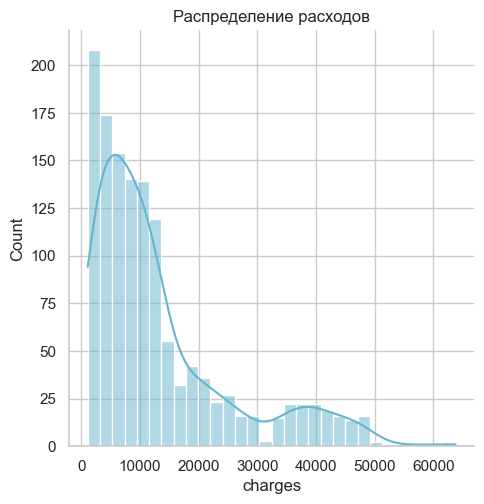

In [50]:
sns.set(style='whitegrid')
ax = sns.displot(df['charges'], kde = True, color = 'c')
plt.title('Распределение расходов')

По графику сверху заметно, что распределение асимметрично. Больше всего людей платят в районе 10000 долларов за страховку.

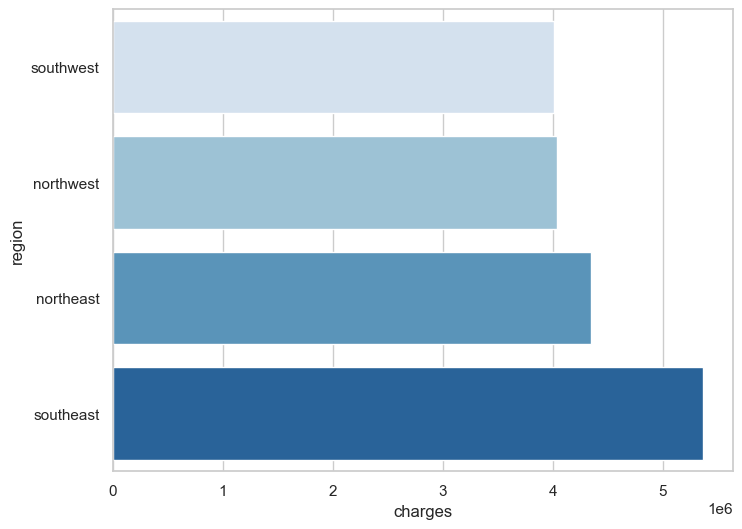

In [51]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x=charges.head(), y=charges.head().index, palette='Blues')

Понятно, что больше всего расходов среди людей из юго-востока, а меньше всего - на юго-западе. Посмотрим на это в зависимости от пола, курения и количества детей.

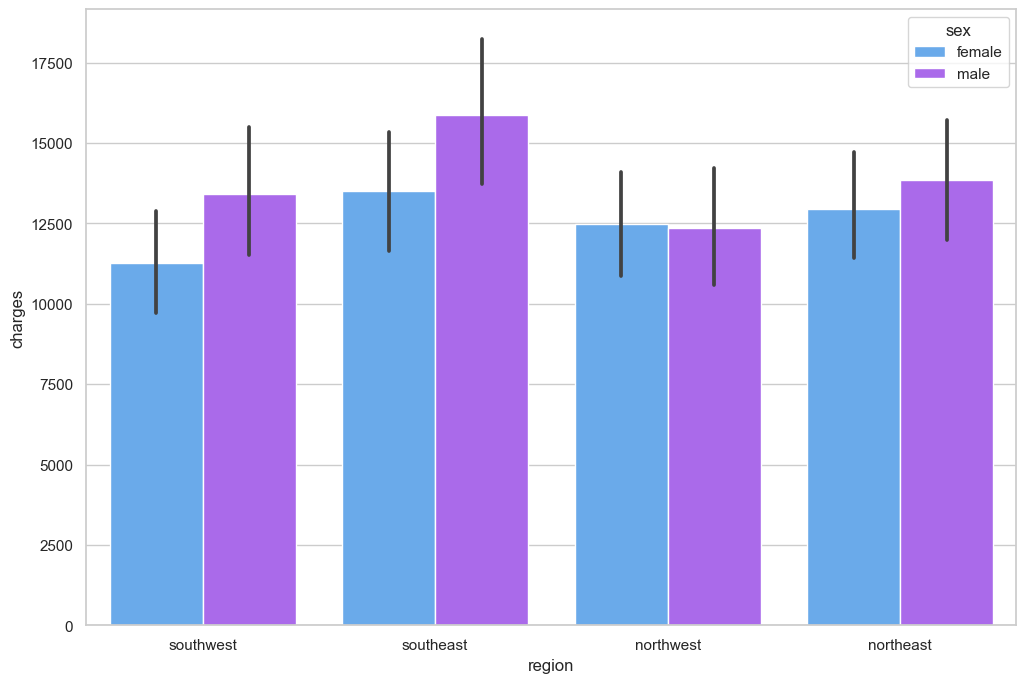

In [52]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

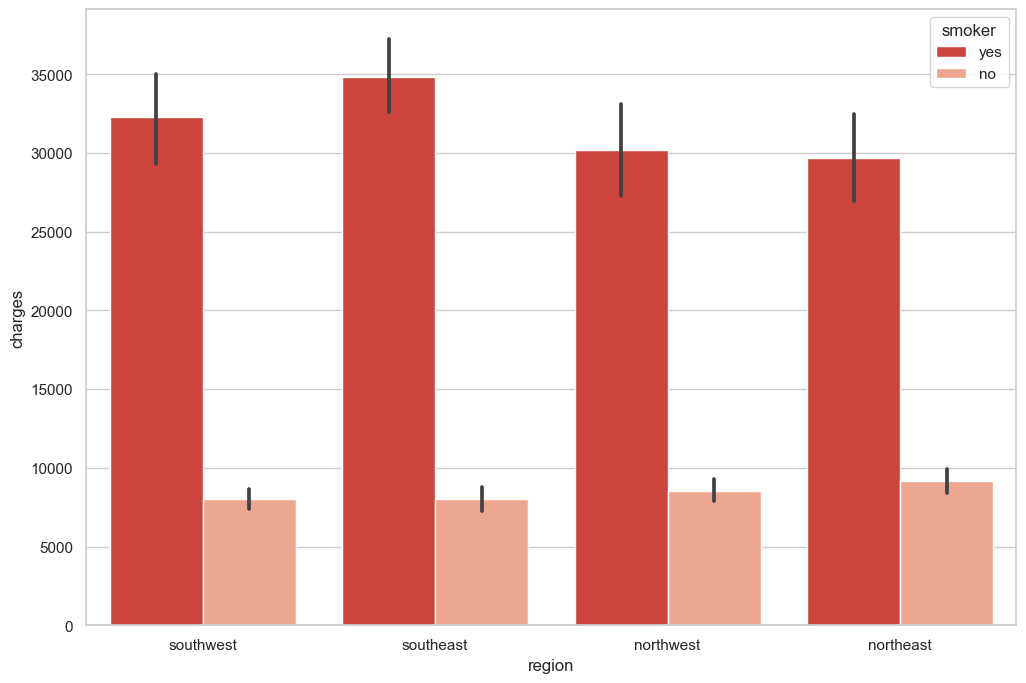

In [53]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df, palette='Reds_r')

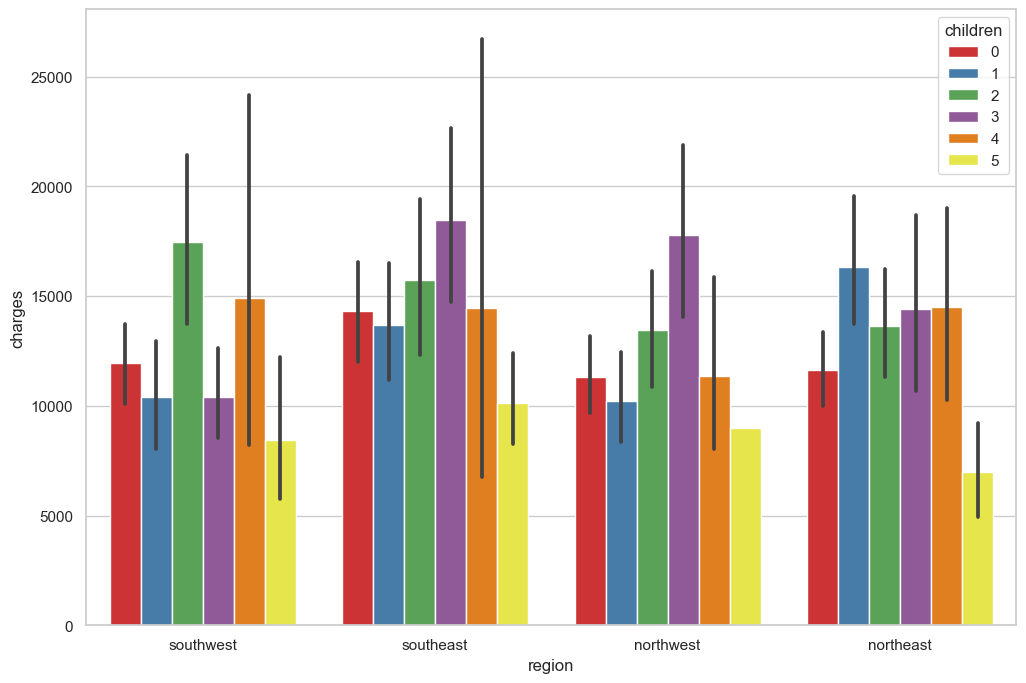

In [54]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')

Из этих диаграмм можно сделать следующие выводы:
- Курящие имеют большие расходы, чем некурящие
- На юго-востоке курящие имеют самые большие расходы, а на северо-востоке - самые низкие
- На юго-востоке мужчины больше всего платят, там же больше всего платят курящие люди
- У людей с детьми, как правило, больше расходов, чем у людей без детей

Кажется логичным, что курящие вынуждены больше платить за медицинскую страховку. Посмотрим на показатели расходов в зависимости от возраста, индекса массы тела и количества детей, но теперь деля по признаку курения.

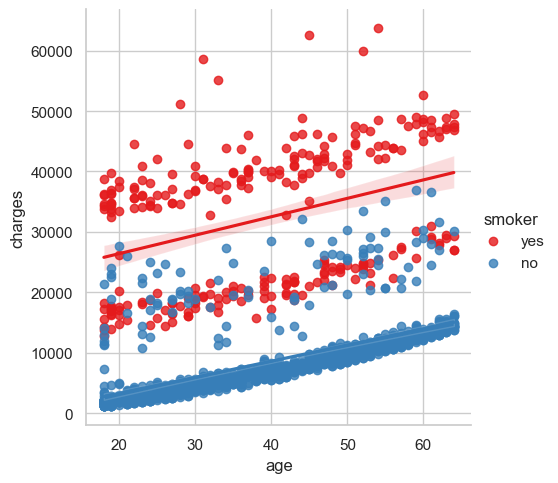

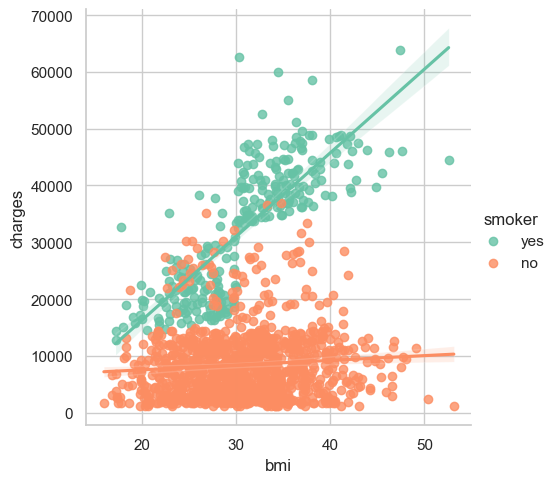

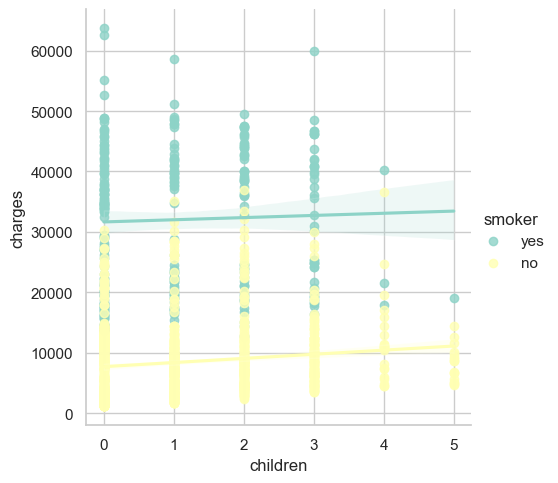

In [55]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

Можно сделать следующие выводы:
- Количество расходов растет с увеличением возраста, индекса массы тела и количества детей
- Среди курящих гораздо меньше тех, у кого есть дети
- У курящих людей расходы очень сильно повышаются. Можно сказать, что пристрастие к курению дает наибольший эффект на медицинские расходы

Последние 2 пункта можно более наглядно продемонстрировать через диаграмму скрипок:

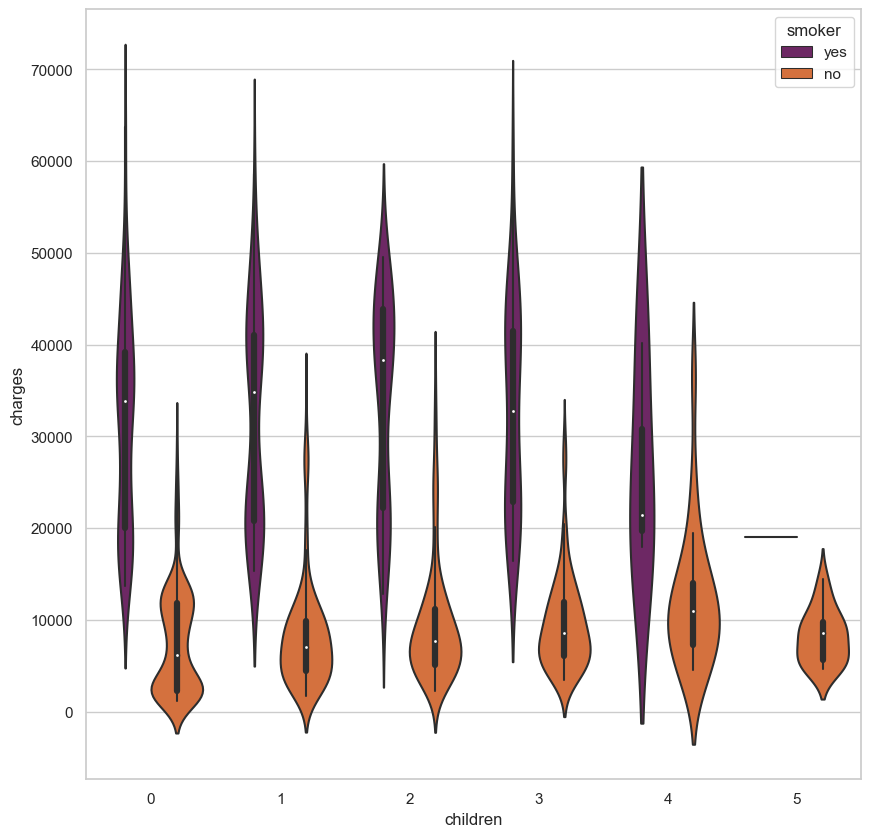

In [56]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df, orient='v', hue='smoker', palette='inferno')

Заметим, что у нас есть 3 категориальных признака: пол, курение и регион. Мы можем преобразовать их в численные:

In [57]:
label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

Теперь мы можем построить диаграмму корреляции

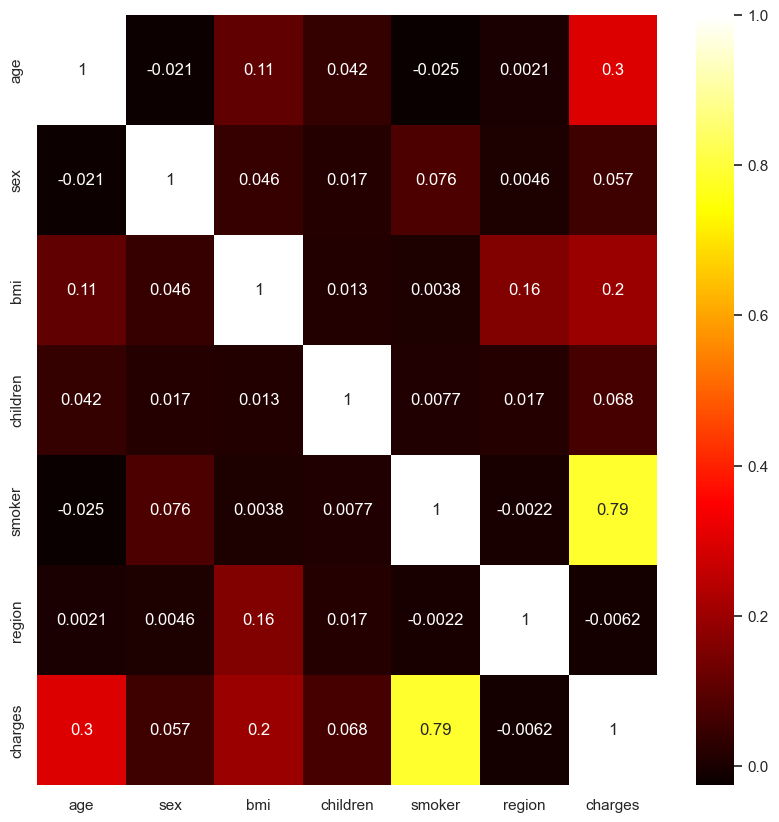

In [58]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='hot')

Можно заметить, что наибольшая корреляция наблюдается между курением и количеством расходов. Между другими признаками корреляции почти не наблюдается.

# Разбиение выборки на обучающую и тестовую